In [1]:
from inference.snpe.snpe_c import SNPE_C as SNPE
from inference.base import *

import utils as utils
from utils.get_nn_models import *
from utils.sbiutils import *
from utils.torchutils import *
import torch
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from torch import nn
import seaborn as sns
import random
import pickle
import io

from simulators.ricker import ricker
from utils.corruption import sparsity, magnitude
from networks.summary_nets import RickerSummary

In [2]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)
        
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Ricker model

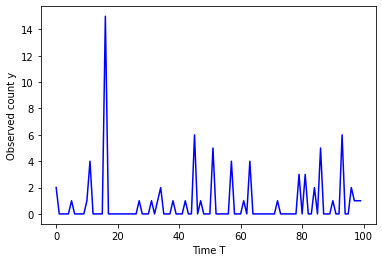

In [23]:
# prior of log r ~ U(3,8), phi ~ U(0,20)
theta = torch.tensor([4, 0.2])
T = 100

Y = ricker(theta)

plt.plot(range(T), Y[1], color="blue")
plt.xlabel("Time T")
plt.ylabel("Observed count y")
plt.show()

In [3]:
low = torch.tensor([2., 0.]).to(device)
high = torch.tensor([8., 20.]).to(device)
prior = torch.distributions.uniform.Uniform(low, high)

num_simulations = 2000

In [11]:
# we can load data directly or simulate from scratch

# theta, x = simulate_for_sbi(ricker, prior, num_simulations=num_simulations)
# x = x.reshape(num_simulations, 100, 100).to(device)
# theta = theta.to(device)
# np.save("x.npy", x)
# np.save("theta.npy", theta)

# x = torch.tensor(np.load("data/x.npy")).to(device)
# x_corrupted = torch.tensor(np.load("data/x_corrupted.npy")).to(device)
theta = torch.tensor(np.load("data/ricker_theta_1000.npy")).to(device)

/Users/huangd5/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

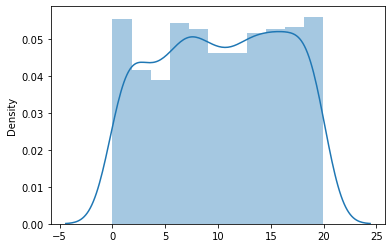

In [19]:
sns.distplot(theta[:, 1])

tensor([7.0862, 4.7482])


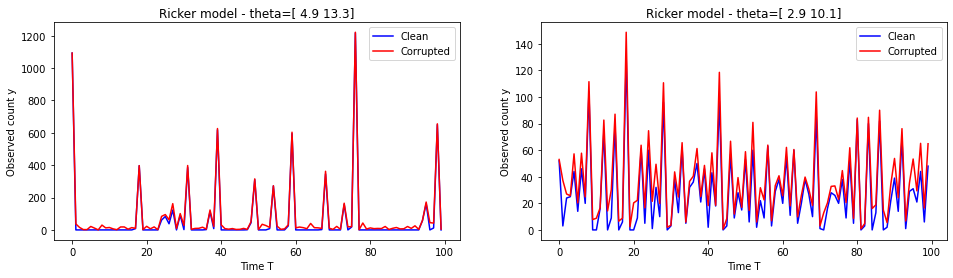

In [55]:
print(theta[4])
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(range(T), x_corrupted[9][0][2], color="blue", label="Clean")
plt.plot(range(T), x_corrupted[9][3][2], color="red", label="Corrupted")
plt.xlabel("Time T")
plt.ylabel("Observed count y")
plt.title("Ricker model - theta={theta}".format(theta=str(np.round(theta[9].detach().numpy(),1))))
plt.legend(loc=1)

plt.subplot(1,2,2)
plt.plot(range(T), x_corrupted[3][0][2], color="blue", label="Clean")
plt.plot(range(T), x_corrupted[3][3][2], color="red", label="Corrupted")
plt.xlabel("Time T")
plt.ylabel("Observed count y")
plt.title("Ricker model - theta={theta}".format(theta=str(np.round(theta[3].detach().numpy(),1))))
plt.legend(loc=1)

plt.savefig("corruption_ricker.pdf")

### "dist_minimize" parameter in train() function indicates whether we do distance minimization

In [ ]:
# Train a normal model without distance minimization
sum_net_normal = RickerSummary(input_size=1, hidden_dim=4).to(device)
neural_posterior_normal = posterior_nn(
    model="maf", 
    embedding_net=sum_net_normal, 
    hidden_features=20, 
    num_transforms=3)

inference_normal = SNPE(prior=prior, density_estimator=neural_posterior_normal, device="cuda:0")
density_estimator_normal = inference_normal.append_simulations(theta, x).train(corrupt_data_training="none")
posterior_normal = inference_normal.build_posterior(density_estimator_normal)

In [ ]:
# Our distance minimization method
sum_net_robust = RickerSummary(input_size=1, hidden_dim=4).to(device)
neural_posterior_robust = posterior_nn(
    model="maf", 
    embedding_net=sum_net_robust, 
    hidden_features=20, 
    num_transforms=3)
theta = theta.to(device)
x = x.to(device)
inference_robust = SNPE(prior=prior, density_estimator=neural_posterior_robust, device="cuda:0")
density_estimator_robust = inference_robust.append_simulations(theta, x).train(corrupt_data_training="mmd_dist",
                                                                               corruption_method = "magnitude")
posterior_robust = inference_robust.build_posterior(density_estimator_robust)

In [8]:
# save all the models and objects

torch.save(sum_net_normal, "objects/sum_net_normal_{seed}.pkl".format(seed=seed))
torch.save(density_estimator_normal, "objects/density_estimator_normal_{seed}.pkl".format(seed=seed))
with open("objects/inference_normal_{seed}.pkl".format(seed=seed), "wb") as handle:
    pickle.dump(inference_normal, handle)
with open("objects/posterior_normal_{seed}.pkl".format(seed=seed), "wb") as handle:
    pickle.dump(posterior_normal, handle)
    
    
torch.save(sum_net_robust, "objects/sum_net_robust_{seed}.pkl".format(seed=seed))    
torch.save(density_estimator_robust, "objects/density_estimator_robust_{seed}.pkl".format(seed=seed))
with open("objects/inference_robust_{seed}.pkl".format(seed=seed), "wb") as handle:
    pickle.dump(inference_robust, handle)
with open("objects/posterior_robust_{seed}.pkl".format(seed=seed), "wb") as handle:
    pickle.dump(posterior_robust, handle)

C:\Users\Daolang Huang\OneDrive - Aalto University\Projects\Robust SBI\Robust-SBI\inference\base.py:429: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  warn(


In [11]:
# read all the models and objects
seed = 3

def load_models(model: str, root_name: str, device: torch.device):
    sum_net = torch.load("{root_name}/sum_net_{model}.pkl".format(root_name=root_name, model=model), map_location=device)

    density_estimator = torch.load("{root_name}/density_estimator_{model}.pkl".format(root_name=root_name, model=model), map_location=device)
    with open("{root_name}/inference_{model}.pkl".format(root_name=root_name, model=model), "rb") as handle:
        inference = CPU_Unpickler(handle).load() if device == torch.device('cpu') else pickle.load(handle)
    with open("{root_name}/posterior_{model}.pkl".format(root_name=root_name, model=model), "rb") as handle:
        posterior = CPU_Unpickler(handle).load() if device == torch.device('cpu') else pickle.load(handle)
    
    return sum_net, density_estimator, inference, posterior

In [13]:
# read robust part
root_name = "objects/magnitude_degree=0_var=15_euclidean_beta=1"

sum_net_robust, density_estimator_robust, inference_robust, posterior_robust = load_models("robust", root_name, device)
sum_net_normal, density_estimator_normal, inference_normal, posterior_normal = load_models("normal", root_name, device)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

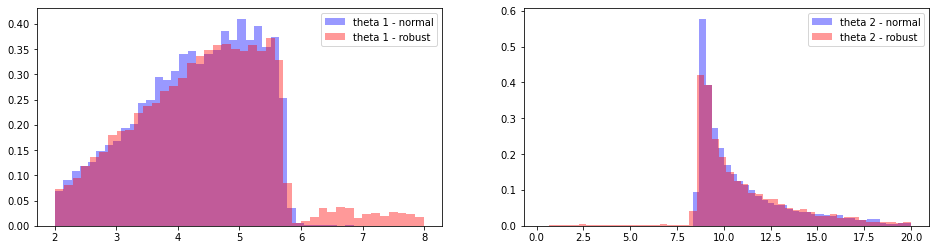

In [15]:
theta_gt = np.array([[4, 10]])

obs = ricker(theta_gt).to(device)

post_samples_normal = posterior_normal.sample((10000,), x=obs.reshape(1, 100, 100))
post_samples_robust = posterior_robust.sample((10000,), x=obs.reshape(1, 100, 100))

plt.figure(figsize=(16,4))
plt.subplot(1, 2, 1)
sns.distplot(post_samples_normal[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="theta 1 - normal")
sns.distplot(post_samples_robust[:, 0].cpu().numpy(), color='red', kde=False, norm_hist=True, label="theta 1 - robust")
plt.legend()
plt.subplot(1, 2, 2)
sns.distplot(post_samples_normal[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="theta 2 - normal")
sns.distplot(post_samples_robust[:, 1].cpu().numpy(), color='red', kde=False, norm_hist=True, label="theta 2 - robust")
plt.legend()

plt.show()

/Users/huangd5/Library/CloudStorage/OneDrive-AaltoUniversity/Projects/Robust SBI/Robust-SBI/simulators/ricker.py:23: RuntimeWarning: divide by zero encountered in log
  Nt[t] = np.exp(logr + np.log(Nt[t - 1]) - Nt[t - 1] + sigma * et[t - 1])


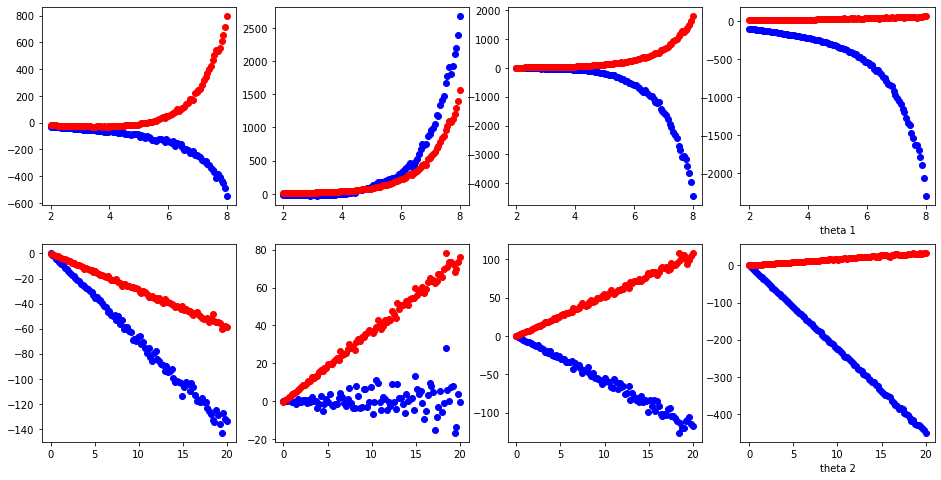

In [24]:
n_samples = 100

theta_1 = np.linspace(2, 8, 100)
theta_2= np.linspace(0, 20, 100)
theta_1_unchange = np.repeat(4, 100)
theta_2_unchange = np.repeat(10, 100)

thetas_1 = np.stack((theta_1, theta_2_unchange), axis=-1)
thetas_2 = np.stack((theta_1_unchange, theta_2), axis=-1)

hidden_1_normal = np.zeros((len(thetas_1), 4))
hidden_2_normal = np.zeros((len(thetas_2), 4))
hidden_1_robust = np.zeros((len(thetas_1), 4))
hidden_2_robust = np.zeros((len(thetas_2), 4))

for i in range(len(thetas_1)):
    obs_1 = ricker(thetas_1[i].reshape(-1, 2)).reshape(1, n_samples, 100).to(device)
    obs_2 = ricker(thetas_2[i].reshape(-1, 2)).reshape(1, n_samples, 100).to(device)

    hidden_1_normal[i] = sum_net_normal(obs_1)[1].reshape(-1).cpu().detach().numpy()
    hidden_2_normal[i] = sum_net_normal(obs_2)[1].reshape(-1).cpu().detach().numpy()
    hidden_1_robust[i] = sum_net_robust(obs_1)[1].reshape(-1).cpu().detach().numpy()
    hidden_2_robust[i] = sum_net_robust(obs_2)[1].reshape(-1).cpu().detach().numpy()
    

plt.figure(figsize=(16,8))
plt.subplot(2, 4, 1)
plt.scatter(theta_1, hidden_1_normal[:, 0], color="blue")
plt.scatter(theta_1, hidden_1_robust[:, 0], color="red")
plt.subplot(2, 4, 2)
plt.scatter(theta_1, hidden_1_normal[:, 1], color="blue")
plt.scatter(theta_1, hidden_1_robust[:, 1], color="red")
plt.subplot(2, 4, 3)
plt.scatter(theta_1, hidden_1_normal[:, 2], color="blue")
plt.scatter(theta_1, hidden_1_robust[:, 2], color="red")
plt.subplot(2, 4, 4)
plt.scatter(theta_1, hidden_1_normal[:, 3], color="blue")
plt.scatter(theta_1, hidden_1_robust[:, 3], color="red")
plt.xlabel("theta 1")

plt.subplot(2, 4, 5)
plt.scatter(theta_2, hidden_2_normal[:, 0], color="blue")
plt.scatter(theta_2, hidden_2_robust[:, 0], color="red")
plt.subplot(2, 4, 6)
plt.scatter(theta_2, hidden_2_normal[:, 1], color="blue")
plt.scatter(theta_2, hidden_2_robust[:, 1], color="red")
plt.subplot(2, 4, 7)
plt.scatter(theta_2, hidden_2_normal[:, 2], color="blue")
plt.scatter(theta_2, hidden_2_robust[:, 2], color="red")
plt.subplot(2, 4, 8)
plt.scatter(theta_2, hidden_2_normal[:, 3], color="blue")
plt.scatter(theta_2, hidden_2_robust[:, 3], color="red")
plt.xlabel("theta 2")

plt.show()

# Corruption

In [14]:
def sparsity(obs):
    obs_cont = np.copy(obs)
    
    for i in range(obs.shape[0]):
        non_zero = np.nonzero(obs_cont[i])[0]
        random.shuffle(non_zero)
        cont_index = non_zero[0: int(0.3*len(non_zero))]
        obs_cont[i][cont_index] = 0

    obs_cont = torch.tensor(obs_cont)
    return obs_cont

In [15]:
def sparsity_2(obs):
    obs_cont = torch.clone(obs).to(obs.device)
    num_cont = int(obs.shape[0])

    for i in range(num_cont):
        # start = random.randint(0, 80)
        # obs_cont[i, start:start+20] = 0
        obs_cont[i, 20:40] = 0

    # obs_cont = torch.tensor(obs_cont)
    return obs_cont

In [4]:
def magnitude(obs):
    obs_cont = torch.clone(obs).to(obs.device)
    for i in range(obs.shape[0]):
        obs_cont[i] += torch.abs(torch.randn(100).to(obs.device) * 15)

    # obs_cont = torch.tensor(obs_cont)
    return obs_cont

tensor([ 4.7555, 12.8447])


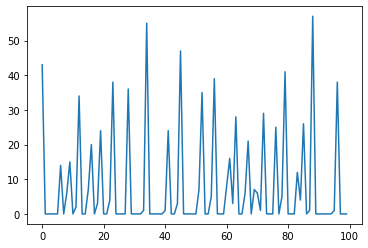

In [25]:
print(theta[2])
ricker(theta[5].reshape(1, 2)).shape
plt.plot(range(100), ricker(theta[21].reshape(1, 2))[10])

torch.Size([100, 100])


/var/folders/h_/4nmj4c_s4z3g9k27jvr24shm0000gp/T/ipykernel_16938/4220671723.py:7: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:2985.)
  plt.plot(range(T), obs[1].cpu().T)


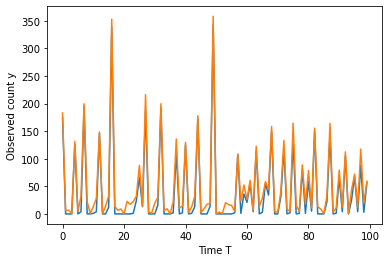

In [26]:
theta_gt = np.array([[4, 10]])

obs = ricker(theta_gt).to(device)
obs_cont = magnitude(obs).to(device)

print(obs.shape)
plt.plot(range(T), obs[1].cpu().T)
plt.plot(range(T), obs_cont[1].cpu().T)
plt.xlabel("Time T")
plt.ylabel("Observed count y")
plt.show()

In [27]:
hidden = np.zeros((2, 4))
hidden[0] = sum_net_robust(obs.reshape(1, 100, 100))[1].reshape(-1).cpu().detach().numpy()
hidden[1] = sum_net_robust(obs_cont.reshape(1, 100, 100))[1].reshape(-1).cpu().detach().numpy()

plt.scatter(range(4), hidden[0].T)
plt.scatter(range(4), hidden[1].T)
plt.show()

NameError: name 'sum_net_robust' is not defined

C:\Users\Daolang Huang\OneDrive - Aalto University\Projects\Robust SBI\Robust-SBI\simulators\ricker.py:23: RuntimeWarning: divide by zero encountered in log
  Nt[t] = np.exp(logr + np.log(Nt[t - 1]) - Nt[t - 1] + sigma * et[t - 1])


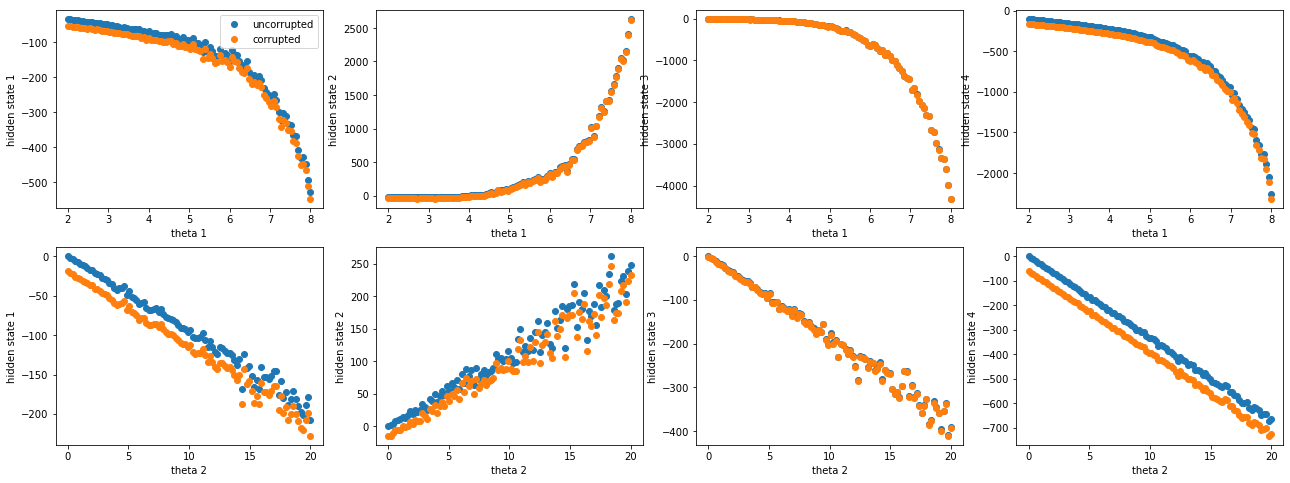

In [25]:
n_samples = 100

theta_1 = np.linspace(2, 8, 100)
theta_2= np.linspace(0, 20, 100)
theta_1_unchange = np.repeat(5, 100)
theta_2_unchange = np.repeat(10, 100)

thetas_1 = np.stack((theta_1, theta_2_unchange), axis=-1)
thetas_2 = np.stack((theta_1_unchange, theta_2), axis=-1)

hidden_1 = np.zeros((len(thetas_1), 8))
hidden_2 = np.zeros((len(thetas_2), 8))

for i in range(len(thetas_1)):
    obs_1 = ricker(thetas_1[i].reshape(-1, 2))
    obs_2 = ricker(thetas_2[i].reshape(-1, 2))
    
    obs_1_cont = magnitude(obs_1).reshape(1, n_samples, 100).to(device)
    obs_2_cont = magnitude(obs_2).reshape(1, n_samples, 100).to(device)
    
    obs_1 = obs_1.reshape(1, n_samples, 100).to(device)
    obs_2 = obs_2.reshape(1, n_samples, 100).to(device)
    

    hidden_1[i, 0:4] = sum_net_normal(obs_1)[1].reshape(-1).cpu().detach().numpy()
    hidden_2[i, 0:4] = sum_net_normal(obs_2)[1].reshape(-1).cpu().detach().numpy()
    
    hidden_1[i, 4:] = sum_net_normal(obs_1_cont)[1].reshape(-1).cpu().detach().numpy()
    hidden_2[i, 4:] = sum_net_normal(obs_2_cont)[1].reshape(-1).cpu().detach().numpy()

plt.figure(figsize=(22,8))
plt.subplot(2, 4, 1)
plt.scatter(theta_1, hidden_1[:, 0], label="uncorrupted")
plt.scatter(theta_1, hidden_1[:, 4], label="corrupted")
plt.xlabel("theta 1")
plt.ylabel("hidden state 1")
plt.legend()
plt.subplot(2, 4, 2)
plt.scatter(theta_1, hidden_1[:, 1])
plt.scatter(theta_1, hidden_1[:, 5])
plt.xlabel("theta 1")
plt.ylabel("hidden state 2")
plt.subplot(2, 4, 3)
plt.scatter(theta_1, hidden_1[:, 2])
plt.scatter(theta_1, hidden_1[:, 6])
plt.xlabel("theta 1")
plt.ylabel("hidden state 3")
plt.subplot(2, 4, 4)
plt.scatter(theta_1, hidden_1[:, 3])
plt.scatter(theta_1, hidden_1[:, 7])
plt.xlabel("theta 1")
plt.ylabel("hidden state 4")

plt.subplot(2, 4, 5)
plt.scatter(theta_2, hidden_2[:, 0])
plt.scatter(theta_2, hidden_2[:, 4])
plt.xlabel("theta 2")
plt.ylabel("hidden state 1")
plt.subplot(2, 4, 6)
plt.scatter(theta_2, hidden_2[:, 1])
plt.scatter(theta_2, hidden_2[:, 5])
plt.xlabel("theta 2")
plt.ylabel("hidden state 2")
plt.subplot(2, 4, 7)
plt.scatter(theta_2, hidden_2[:, 2])
plt.scatter(theta_2, hidden_2[:, 6])
plt.xlabel("theta 2")
plt.ylabel("hidden state 3")
plt.subplot(2, 4, 8)
plt.scatter(theta_2, hidden_2[:, 3])
plt.scatter(theta_2, hidden_2[:, 7])
plt.xlabel("theta 2")
plt.ylabel("hidden state 4")
# plt.savefig("hidden_layer_ricker.pdf")
plt.show()

/Users/huangd5/Library/CloudStorage/OneDrive-AaltoUniversity/Projects/Robust SBI/Robust-SBI/simulators/ricker.py:23: RuntimeWarning: divide by zero encountered in log
  Nt[t] = np.exp(logr + np.log(Nt[t - 1]) - Nt[t - 1] + sigma * et[t - 1])


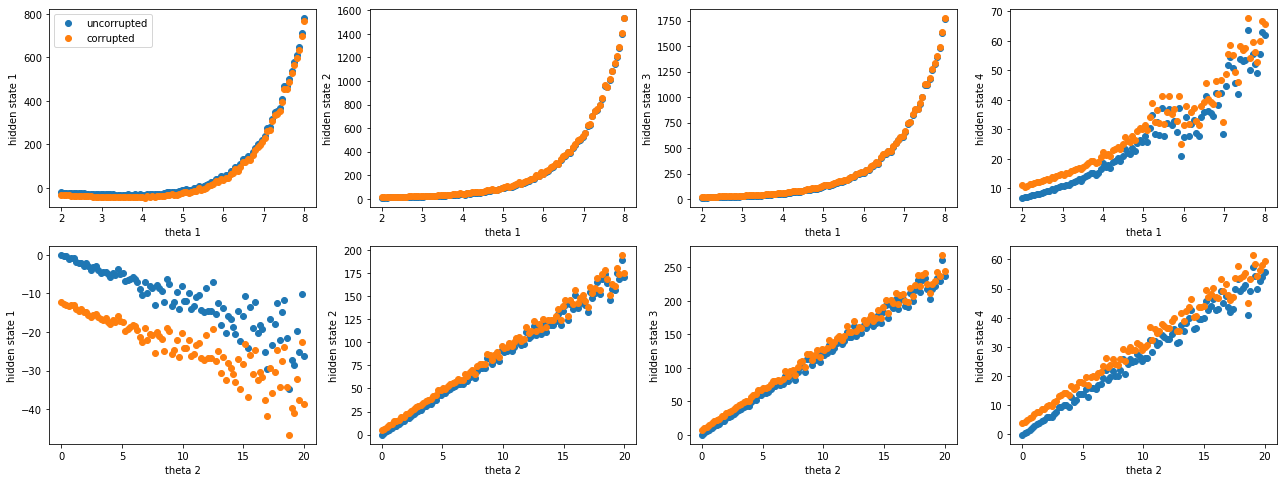

In [18]:
n_samples = 100

theta_1 = np.linspace(2, 8, 100)
theta_2= np.linspace(0, 20, 100)
theta_1_unchange = np.repeat(5, 100)
theta_2_unchange = np.repeat(10, 100)

thetas_1 = np.stack((theta_1, theta_2_unchange), axis=-1)
thetas_2 = np.stack((theta_1_unchange, theta_2), axis=-1)

hidden_1 = np.zeros((len(thetas_1), 8))
hidden_2 = np.zeros((len(thetas_2), 8))

for i in range(len(thetas_1)):
    obs_1 = ricker(thetas_1[i].reshape(-1, 2))
    obs_2 = ricker(thetas_2[i].reshape(-1, 2))
    
    obs_1_cont = magnitude(obs_1).reshape(1, n_samples, 100).to(device)
    obs_2_cont = magnitude(obs_2).reshape(1, n_samples, 100).to(device)
    
    obs_1 = obs_1.reshape(1, n_samples, 100).to(device)
    obs_2 = obs_2.reshape(1, n_samples, 100).to(device)
    

    hidden_1[i, 0:4] = sum_net_robust(obs_1)[1].reshape(-1).cpu().detach().numpy()
    hidden_2[i, 0:4] = sum_net_robust(obs_2)[1].reshape(-1).cpu().detach().numpy()
    
    hidden_1[i, 4:] = sum_net_robust(obs_1_cont)[1].reshape(-1).cpu().detach().numpy()
    hidden_2[i, 4:] = sum_net_robust(obs_2_cont)[1].reshape(-1).cpu().detach().numpy()

plt.figure(figsize=(22,8))
plt.subplot(2, 4, 1)
plt.scatter(theta_1, hidden_1[:, 0], label="uncorrupted")
plt.scatter(theta_1, hidden_1[:, 4], label="corrupted")
plt.xlabel("theta 1")
plt.ylabel("hidden state 1")
plt.legend()
plt.subplot(2, 4, 2)
plt.scatter(theta_1, hidden_1[:, 1])
plt.scatter(theta_1, hidden_1[:, 5])
plt.xlabel("theta 1")
plt.ylabel("hidden state 2")
plt.subplot(2, 4, 3)
plt.scatter(theta_1, hidden_1[:, 2])
plt.scatter(theta_1, hidden_1[:, 6])
plt.xlabel("theta 1")
plt.ylabel("hidden state 3")
plt.subplot(2, 4, 4)
plt.scatter(theta_1, hidden_1[:, 3])
plt.scatter(theta_1, hidden_1[:, 7])
plt.xlabel("theta 1")
plt.ylabel("hidden state 4")

plt.subplot(2, 4, 5)
plt.scatter(theta_2, hidden_2[:, 0])
plt.scatter(theta_2, hidden_2[:, 4])
plt.xlabel("theta 2")
plt.ylabel("hidden state 1")
plt.subplot(2, 4, 6)
plt.scatter(theta_2, hidden_2[:, 1])
plt.scatter(theta_2, hidden_2[:, 5])
plt.xlabel("theta 2")
plt.ylabel("hidden state 2")
plt.subplot(2, 4, 7)
plt.scatter(theta_2, hidden_2[:, 2])
plt.scatter(theta_2, hidden_2[:, 6])
plt.xlabel("theta 2")
plt.ylabel("hidden state 3")
plt.subplot(2, 4, 8)
plt.scatter(theta_2, hidden_2[:, 3])
plt.scatter(theta_2, hidden_2[:, 7])
plt.xlabel("theta 2")
plt.ylabel("hidden state 4")
# plt.savefig("hidden_layer_ricker.pdf")
plt.show()

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
# from rnpe.tasks import Gaussian
from jax import random
import numpy as np

seed = 1
slab_scale = 0.25
hyperprior=False
misspecified = True
file = f"seed={seed}_slab_scale={slab_scale}_hyperprior={hyperprior}_misspecified={misspecified}"
results_dir = "../rnpe/results"
fn = f"{results_dir}/Ricker/{file}.pickle"


plt.rcParams['axes.grid'] = False

with open(fn, "rb") as f:
    results = pickle.load(f)

rnpe_posterior_samples = np.array(results['posterior_samples']['RNPE'])

In [40]:
seed = 2
slab_scale = 0.25
hyperprior=False
misspecified = False
file = f"seed={seed}_slab_scale={slab_scale}_hyperprior={hyperprior}_misspecified={misspecified}"
results_dir = "../rnpe/results"
fn = f"{results_dir}/Ricker/{file}.pickle"


plt.rcParams['axes.grid'] = False

with open(fn, "rb") as f:
    results_well = pickle.load(f)

rnpe_posterior_samples_well = np.array(results_well['posterior_samples']['RNPE'])

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([10000, 2])


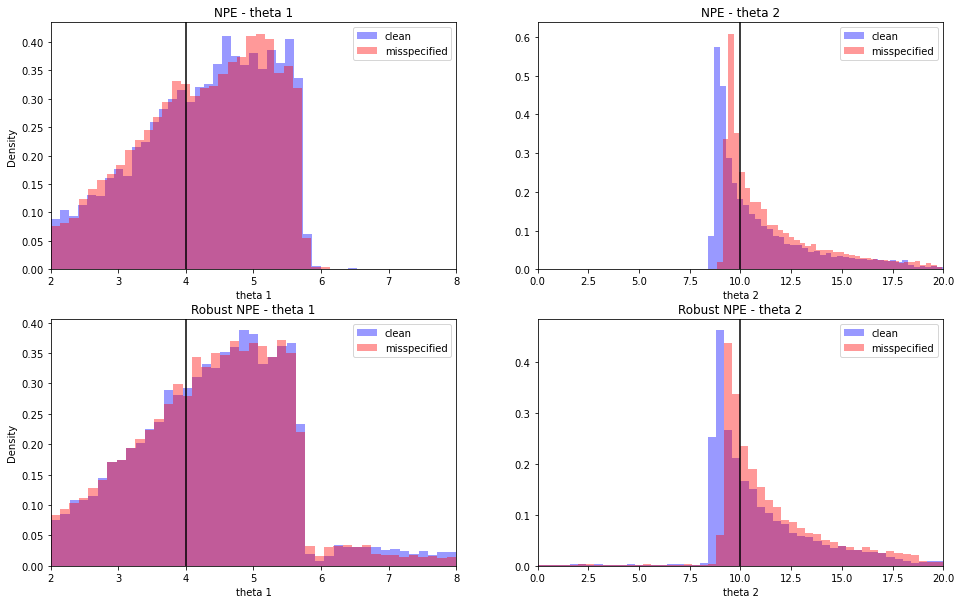

In [16]:
theta_gt = np.array([[4, 10]])

obs = ricker(theta_gt).to(device)
obs_cont = magnitude(obs)

post_samples_normal = posterior_normal.sample((10000,), x=obs.reshape(1, 100, 100))
post_samples_cont_normal = posterior_normal.sample((10000,), x=obs_cont.reshape(1, 100, 100))
post_samples_robust = posterior_robust.sample((10000,), x=obs.reshape(1, 100, 100))
post_samples_cont_robust = posterior_robust.sample((10000,), x=obs_cont.reshape(1, 100, 100))
print(post_samples_robust.shape)

plt.figure(figsize=(16,10))
plt.subplot(2, 2, 1)
sns.distplot(post_samples_normal[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="clean")
sns.distplot(post_samples_cont_normal[:, 0].cpu().numpy(), color="red", kde=False, norm_hist=True, label="misspecified")
plt.xlim(2, 8)
plt.ylabel("Density")
plt.xlabel("theta 1")
plt.title("NPE - theta 1")
plt.axvline(x=theta_gt[0][0],ls="-",c="black")
plt.legend()

plt.subplot(2, 2, 2)
sns.distplot(post_samples_normal[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="clean")
sns.distplot(post_samples_cont_normal[:, 1].cpu().numpy(), color="red", kde=False, norm_hist=True, label="misspecified")
plt.xlim(0, 20)
plt.xlabel("theta 2")
plt.title("NPE - theta 2")
plt.axvline(x=theta_gt[0][1],ls="-",c="black")
plt.legend()

plt.subplot(2, 2, 3)
sns.distplot(post_samples_robust[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="clean")
sns.distplot(post_samples_cont_robust[:, 0].cpu().numpy(), color="red", kde=False, norm_hist=True, label="misspecified")
# sns.distplot(rnpe_posterior_samples[:, 0], color='yellow', kde=False, norm_hist=True, label="rnpe")
# sns.distplot(rnpe_posterior_samples_well[:, 0], color='green', kde=False, norm_hist=True, label="rnpe")
plt.xlim(2, 8)
plt.ylabel("Density")
plt.xlabel("theta 1")
plt.title("Robust NPE - theta 1")
plt.axvline(x=theta_gt[0][0],ls="-",c="black")
plt.legend()

plt.subplot(2, 2, 4)
sns.distplot(post_samples_robust[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="clean")
sns.distplot(post_samples_cont_robust[:, 1].cpu().numpy(), color="red", kde=False, norm_hist=True, label="misspecified")
# sns.distplot(rnpe_posterior_samples[:, 1], color='yellow', kde=False, norm_hist=True, label="rnpe")
# sns.distplot(rnpe_posterior_samples_well[:, 1], color='green', kde=False, norm_hist=True, label="rnpe")
plt.xlim(0, 20)
plt.xlabel("theta 2")
plt.title("Robust NPE - theta 2")
plt.axvline(x=theta_gt[0][1],ls="-",c="black")

plt.legend()
plt.show()

In [62]:
from utils.metrics import *
theta_gt = np.array([[4, 10]])

obs = ricker(theta_gt).to(device)
obs_cont = magnitude(obs).to(device)
print(x.shape)
unbiased_mmd_squared(sum_net_normal(x[1:3])[0].reshape(200, 4), sum_net_normal(x[3:5])[0].reshape(200, 4))

torch.Size([2000, 100, 100])


tensor(0.6820, grad_fn=<MulBackward0>)

# Change magnitude

In [564]:
def magnitude_cont(obs):
    obs_cont = np.copy(obs)
    
    for i in range(obs.shape[0]):
#         non_zero = np.nonzero(obs_cont[i])[0]
#         random.shuffle(non_zero)
#         cont_index = non_zero[0: int(1*len(non_zero))]
        obs_cont[i] -= np.random.randn(100)*50

    obs_cont = torch.tensor(obs_cont)
    return obs_cont

torch.Size([100, 100])


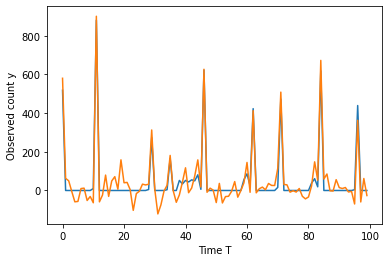

In [596]:
theta_obs = np.array([[5, 10]])

obs = ricker(theta_obs)
obs_cont = magnitude_cont(obs)
print(obs.shape)
plt.plot(range(T), obs[1].T)
plt.plot(range(T), obs_cont[1].T)
plt.xlabel("Time T")
plt.ylabel("Observed count y")
plt.show()

In [594]:
n_samples = 100

theta_1 = np.linspace(3, 8, 100)
theta_2= np.linspace(0, 20, 100)
theta_1_unchange = np.repeat(5, 100)
theta_2_unchange = np.repeat(10, 100)

thetas_1 = np.stack((theta_1, theta_2_unchange), axis=-1)
thetas_2 = np.stack((theta_1_unchange, theta_2), axis=-1)

hidden_1 = np.zeros((len(thetas_1), 8))
hidden_2 = np.zeros((len(thetas_2), 8))

for i in range(len(thetas_1)):
    obs_1 = ricker(thetas_1[i].reshape(-1, 2))
    obs_2 = ricker(thetas_2[i].reshape(-1, 2))
    
    obs_1_cont = sparsity_cont(obs_1).reshape(1, n_samples, 100)
    obs_2_cont = sparsity_cont(obs_2).reshape(1, n_samples, 100)
    
    obs_1 = obs_1.reshape(1, n_samples, 100)
    obs_2 = obs_2.reshape(1, n_samples, 100)
    

    hidden_1[i, 0:4] = model(obs_1).reshape(-1).detach().numpy()
    hidden_2[i, 0:4] = model(obs_2).reshape(-1).detach().numpy()
    
    hidden_1[i, 4:] = model(obs_1_cont).reshape(-1).detach().numpy()
    hidden_2[i, 4:] = model(obs_2_cont).reshape(-1).detach().numpy()

plt.figure(figsize=(16,8))
plt.subplot(2, 4, 1)
plt.scatter(theta_1, hidden_1[:, 0])
plt.scatter(theta_1, hidden_1[:, 4])
plt.subplot(2, 4, 2)
plt.scatter(theta_1, hidden_1[:, 1])
plt.scatter(theta_1, hidden_1[:, 5])
plt.subplot(2, 4, 3)
plt.scatter(theta_1, hidden_1[:, 2])
plt.scatter(theta_1, hidden_1[:, 6])
plt.subplot(2, 4, 4)
plt.scatter(theta_1, hidden_1[:, 3])
plt.scatter(theta_1, hidden_1[:, 7])
plt.xlabel("theta 1")

plt.subplot(2, 4, 5)
plt.scatter(theta_2, hidden_2[:, 0])
plt.scatter(theta_2, hidden_2[:, 4])
plt.subplot(2, 4, 6)
plt.scatter(theta_2, hidden_2[:, 1])
plt.scatter(theta_2, hidden_2[:, 5])
plt.subplot(2, 4, 7)
plt.scatter(theta_2, hidden_2[:, 2])
plt.scatter(theta_2, hidden_2[:, 6])
plt.subplot(2, 4, 8)
plt.scatter(theta_2, hidden_2[:, 3])
plt.scatter(theta_2, hidden_2[:, 7])
plt.xlabel("theta 2")

plt.show()

KeyboardInterrupt: 

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([10000, 2])


/Users/huangd5/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


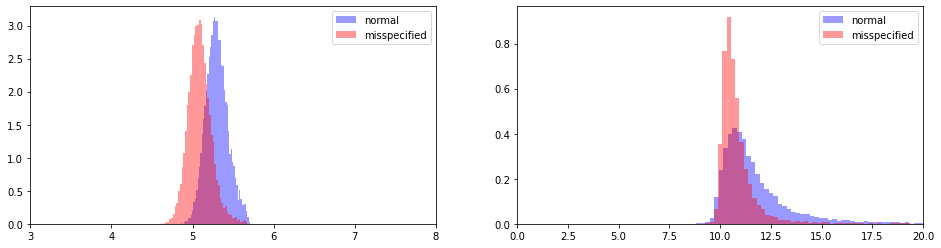

In [597]:
post_samples = posterior.sample((10000,), x=obs.reshape(1, 100, 100))
post_samples_cont = posterior.sample((10000,), x=obs_cont.reshape(1, 100, 100))
print(post_samples.shape)

plt.figure(figsize=(16,4))
plt.subplot(1, 2, 1)
sns.distplot(post_samples[:, 0].numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_cont[:, 0].numpy(), color="red", kde=False, norm_hist=True, label="misspecified")
plt.xlim(3, 8)
plt.legend()
plt.subplot(1, 2, 2)
sns.distplot(post_samples[:, 1].numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_cont[:, 1].numpy(), color="red", kde=False, norm_hist=True, label="misspecified")
plt.xlim(0, 20)

plt.legend()
plt.show()

# Change mean

Here only change 20% data

torch.Size([100, 100])


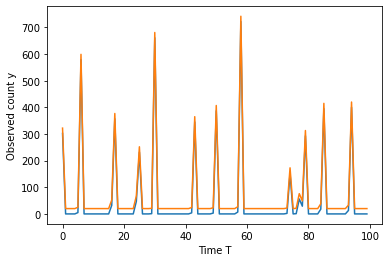

In [579]:
theta_obs = np.array([[5, 10, 0.6]])

obs = ricker(theta_obs)
obs_cont = np.copy(obs)

for i in range(0, int(obs.shape[0]*0.2)):
    obs_cont[i] = obs_cont[i] + 20
print(obs.shape)
plt.plot(range(T), obs[1].T)
plt.plot(range(T), obs_cont[1].T)
plt.xlabel("Time T")
plt.ylabel("Observed count y")
plt.show()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([10000, 2])


/Users/huangd5/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


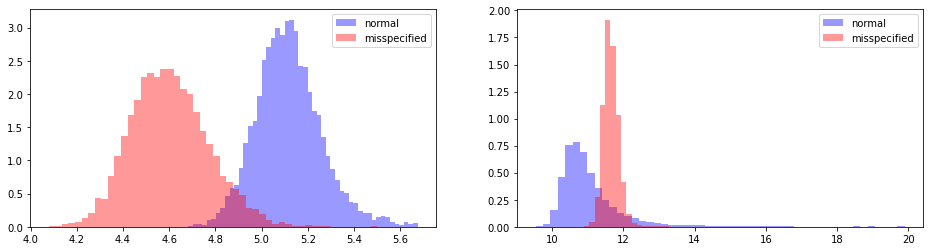

In [580]:
post_samples = posterior.sample((10000,), x=obs.reshape(1, 100, 100))
post_samples_cont = posterior.sample((10000,), x=obs_cont.reshape(1, 100, 100))
print(post_samples.shape)

plt.figure(figsize=(16,4))
plt.subplot(1, 2, 1)
sns.distplot(post_samples[:, 0].numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_cont[:, 0].numpy(), color="red", kde=False, norm_hist=True, label="misspecified")
plt.legend()
plt.subplot(1, 2, 2)
sns.distplot(post_samples[:, 1].numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_cont[:, 1].numpy(), color="red", kde=False, norm_hist=True, label="misspecified")

plt.legend()
plt.show()